In [1]:
import random
from IPython.core.display import SVG
import pyomo.environ as pyo
from pysat.solvers import Solver
from pysat.formula import CNF 
import py_svg_combinatorics as psc
from ipywidgets import widgets, HBox
from collections import Counter
from pprint import pprint
from random import randint
import numpy as np
from IPython.display import IFrame
import IPython
from copy import copy
import os
from pathlib import Path
nbname = ''
try:
    nbname = __vsc_ipynb_file__
except:
    if 'COCALC_JUPYTER_FILENAME' in os.environ:
        nbname = os.environ['COCALC_JUPYTER_FILENAME']    
title_ = Path(nbname).stem.replace('-', '_').title()    
IFrame(f'https://discopal.ispras.ru/index.php?title=Hardprob/{title_}&useskin=cleanmonobook', width=1280, height=300)

In [2]:
def gen_random_problem(max_s, num_el, K):
    s = sorted(np.random.randint(1, max_s, size=(num_el)))
    return s, K

s, K = gen_random_problem(50, 8, 4)
s, K

([2, 5, 16, 24, 26, 32, 35, 44], 4)

#### 1) Простая моделька. 

Переменная $x[i, a] -$ берем ли мы элемент i в подмножество $A_a$.\
Всего одно условие: каждый элемент содержится в одном подмножестве, притом только в одном, то есть
$$\displaystyle\sum_{a=1}^{K}\left( x[i, a] \right) = 1 $$
Соответсвенно, целевая функция будет иметь вид:
$$\displaystyle\sum_{a=1}^{K}\left( \displaystyle\sum_{i\in A_a} s[i] \times x[i, a] \right)^2 \longrightarrow min$$
К сожалению, она не линейная.

**StasFomin**: Ну тут как раз надо было подумать, как сделать ее линейной. У нас было много подобного даже в бизнес-задачах.

In [3]:
def get_model(s, K):
    m = pyo.ConcreteModel()
    # Забираем с собой на всякий
    m.s = s
    # Индексы
    m.A = range(len(s))
    m.K = range(K) 
    # x[i, set_] -- берем ли мы элемент i in m.A в подмножество set_ (A_k)
    m.x = pyo.Var(m.A, m.K, domain=pyo.Binary)

    # Каждый элемент ровно в 1 подмножестве.
    @m.Constraint(m.A)
    def every_elem_is_on_set_and_only_in_one_set(m, elem):
        return sum(m.x[elem, set_] for set_ in m.K) == 1

    # Целевая функция.
    @m.Objective(sense=pyo.minimize)
    def squares_sum(m):
        return sum(sum(s[elem] * m.x[elem, set_]  for elem in m.A) ** 2 for set_ in m.K)

    return m

model = get_model(s, K)
# model.pprint()

In [4]:
solver = pyo.SolverFactory('scip')
solver.solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: 8504.0
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 32
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: optimal solution found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 1.58
  Gap: 0.0
  Primal bound: 8504.0
  Dual bound: 8504.0
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solu

**Визуализация.**

По оси абсцисс отмечены индексы элементов ($i$) и в скобках их веса ($s[i]$). По оси ординат &mdash; множество, в которое берем

In [5]:
def display_model(model):
    subsets = {f'A_{set_}': [] for set_ in model.K}
    for set_ in model.K:
        for elem in model.A:
            if len(list(model.x.extract_values())[0]) == 2:
                ind = model.x[elem, set_]()
            else:
                ind = model.x[elem, elem, set_]()
            if round(ind) == 1:
                subsets[f'A_{set_}'].append(f'{elem}({model.s[elem]})')

    svg = psc.subsets2svg(subsets)
    print(f'Sum of squares: {model.squares_sum()}')
    return SVG(data=svg)

Sum of squares: 8504.0


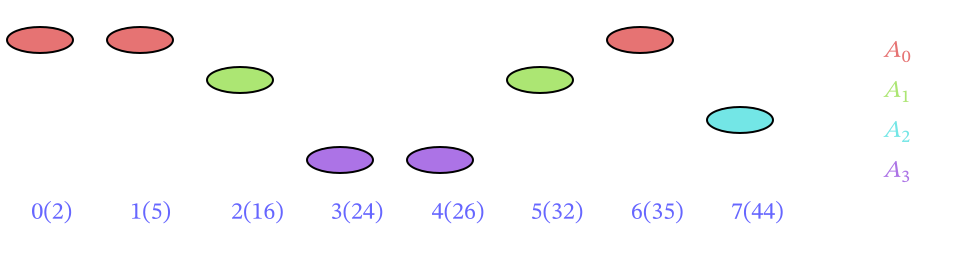

In [15]:

display_model(model)

### 2. Модель посложнее (она теперь линейная)

Идея: сначала раскроем квадрат
$$\displaystyle\sum_{a=1}^{K}\left( \displaystyle\sum_{i\in A_a} s[i] \right)^2 = \displaystyle\sum_{a=1}^{K}\left( \displaystyle\sum_{i\in A_a}\displaystyle\sum_{j\in A_a} s[i] \times s[j] \right)$$
Пусть теперь $x[i,j, a] = x[i, a] \cdot x[j, a] = \mathbb{I} \{ i \in A_a \wedge j \in A_a \} $.
Тогда целевая функция будет иметь вид:
$$\displaystyle\sum_{a=1}^{K}\left( \displaystyle\sum_{i\in A_a}\displaystyle\sum_{j\in A_a} s[i] \times s[j] \times x[i,j,a] \right) \longrightarrow min$$

Построение модели:
- "Диагональные" элементы $x[i,i, a]$ обозначают берем ли мы элемент $i$ в подмножество $A_a$.
- Если $x[i,i, a] = 1$ ($i \in A_a$) и $x[j,j, a] = 1$ ($j \in A_a$), то $x[i,j, a] = x[j,i, a] == 1$. И обратно.
- Отсюда:
    - $x[i,j,a] \leqslant x[i,i,a] ~\forall i,j$ (так модель вынуждена ставить ноль в $x[i,j, a]$, если $i \notin A_a$).
    - $1 + x[i,j,a] \geqslant x[i,i,a] + x[j,j,a] ~\forall  i,j$  (так модель вынуждена ставить 1 в $x[i,j, a]$, если $i \in A_a$ и $j \in A_a$).

In [7]:
def get_lp_model(s, K):
    m = pyo.ConcreteModel()
    m.s = s
    # Индексы
    m.A = range(len(s))
    m.K = range(K)

    m.x = pyo.Var(m.A, m.A, m.K, domain=pyo.Binary)

    @m.Constraint(m.A)
    def belong_to_set(m, elem):
        return sum(m.x[elem, elem, set_] for set_ in m.K) == 1

    # if i,i or j,j not in k then i,j not in k
    @m.Constraint(m.A, m.A, m.K)
    def empty_rows(m, i, j, set_):
        return  m.x[i, j, set_] <= m.x[i, i, set_]

    # if i,i in k and j,j in k then i,j in k
    @m.Constraint(m.A, m.A, m.K)
    def transitive(m, i, j, set_):
        return 1 + m.x[i, j, set_] >= m.x[i, i, set_] + m.x[j, j, set_]

    @m.Objective(sense=pyo.minimize)
    def squares_sum(m):
        return sum(sum(s[left] * s[right] * m.x[left, right, set_] for left in m.A for right in m.A) for set_ in m.K)

    return m

lp_model = get_lp_model(s, K)
# model.pprint()

In [8]:
solver = pyo.SolverFactory('cbc')
solver.solve(lp_model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 8504.0
  Upper bound: 8504.0
  Number of objectives: 1
  Number of constraints: 456
  Number of variables: 256
  Number of binary variables: 256
  Number of integer variables: 256
  Number of nonzeros: 256
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 4.59
  Wallclock time: 5.43
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch an

Sum of squares: 8504.0


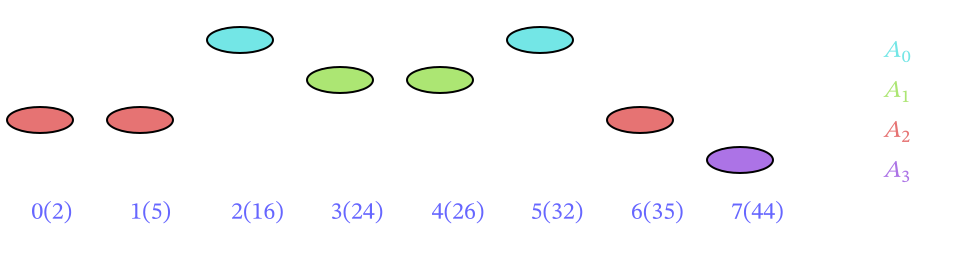

In [10]:
display_model(lp_model)

#### 3. Модель прошлого пункта можно упростить: 

a) Заметим, что модели "не выгодно" ставить в $x[i,j]$ единицу, если она может поставить туда ноль (так как целевая функция на минимум).
Благодаря этому можно выбросить условие `empty_rows`($x[i,j] \leqslant x[i,i]$), так как и без него модель предпочтет ставить 0 в $x[i,j]$. 

b) Также можно заполнять не все $x[i,j]$, а только половину (из симметричной матрицы перейдем в верхнетреугольную).
Tогда нужно скорректировать целевую функцию: квадраты ($x[i,i]$) в сумме должны умножаться на 1, а "перекрестные" элементы ($x[i,j]$) на 2. 

In [16]:
def get_final_model(s, K):
    m = pyo.ConcreteModel()
    m.s = s
    # Индексы
    m.A = range(len(s))
    m.K = range(K)

    m.x = pyo.Var(m.A, m.A, m.K, domain=pyo.Binary)

    @m.Constraint(m.A)
    def every_elem_is_on_set_and_only_in_one_set(m, elem):
        return sum(m.x[elem, elem, set_] for set_ in m.K) == 1

    # if i,i in k and j,j in k then i,j in k
    @m.Constraint(m.A, m.A, m.K)
    def transitive(m, i, j, set_):
        if i <= j:
            return pyo.Constraint.Feasible
        else:
            return 1 + m.x[i,j,set_] >= m.x[i,i,set_] + m.x[j,j,set_]

    @m.Objective(sense=pyo.minimize)
    def squares_sum(m):
        def newton_coef(i, j):
            return 1 if i == j else 2
        return sum(sum(newton_coef(left, right) * s[left] * s[right] * m.x[left, right, set_] for left in m.A for right in m.A) for set_ in m.K)

    return m

model = get_final_model(s, K)

In [17]:
solver = pyo.SolverFactory('cbc')
solver.solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 8504.0
  Upper bound: 8504.0
  Number of objectives: 1
  Number of constraints: 120
  Number of variables: 144
  Number of binary variables: 256
  Number of integer variables: 256
  Number of nonzeros: 144
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 2.07
  Wallclock time: 2.51
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch an

Как мы можем видеть, число условий Constraint уменьшилось почти в 4 раза.

Sum of squares: 8504.0


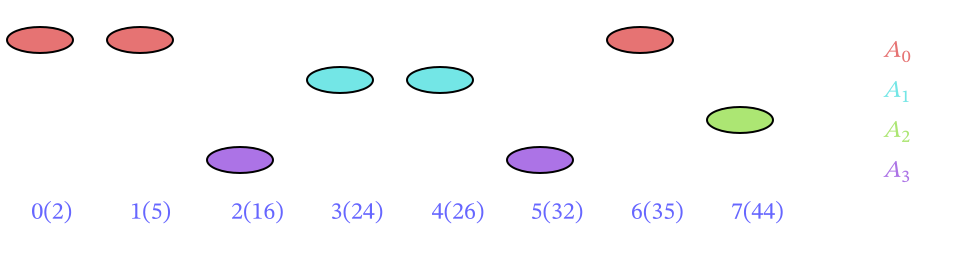

In [21]:
display_model(model)